<a href="https://colab.research.google.com/github/shashwat9kumar/Xethon-2021/blob/main/Retinal_OCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!cp /content/drive/MyDrive/Kaggle/kaggle.json ./

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [3]:
!kaggle datasets download -d paultimothymooney/kermany2018

100% 10.8G/10.8G [04:05<00:00, 6.18MB/s]
100% 10.8G/10.8G [04:05<00:00, 47.4MB/s]


In [4]:
!unzip *.zip

Streaming output truncated to the last 5000 lines.
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8050636-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-4.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-5.jpeg  
  inflating: 

In [5]:
!mv 'OCT2017 ' OCT2017

In [6]:
import os

for root, dirs, files in os.walk("OCT2017"):
    print(f"There are {len(dirs)} directories and {len(files)} files in {root}")

There are 3 directories and 0 files in OCT2017
There are 4 directories and 0 files in OCT2017/train
There are 0 directories and 26315 files in OCT2017/train/NORMAL
There are 0 directories and 11348 files in OCT2017/train/DME
There are 0 directories and 8616 files in OCT2017/train/DRUSEN
There are 0 directories and 37205 files in OCT2017/train/CNV
There are 4 directories and 0 files in OCT2017/test
There are 0 directories and 242 files in OCT2017/test/NORMAL
There are 0 directories and 242 files in OCT2017/test/DME
There are 0 directories and 242 files in OCT2017/test/DRUSEN
There are 0 directories and 242 files in OCT2017/test/CNV
There are 4 directories and 0 files in OCT2017/val
There are 0 directories and 8 files in OCT2017/val/NORMAL
There are 0 directories and 8 files in OCT2017/val/DME
There are 0 directories and 8 files in OCT2017/val/DRUSEN
There are 0 directories and 8 files in OCT2017/val/CNV


In [7]:
train_dir = "OCT2017/train"
test_dir = "OCT2017/test"
valid_dir = "OCT2017/val"

In [8]:
# Setting up data inputs

import tensorflow as tf
IMG_SIZE = (224,224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # Dont shuffle test data for prediction analysis

valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # Dont shuffle test data for prediction analysis

Found 83484 files belonging to 4 classes.
Found 968 files belonging to 4 classes.
Found 32 files belonging to 4 classes.


In [9]:
import random
import matplotlib.pyplot as plt

def plot_random_image(directory, class_names):
    """
    To plot 1 random image from all the classes of the directory specified
    """

    plt.figure(figsize=(10,10))

    total = len(class_names)
    for i in range(total):
        image_path = directory + "/" + class_names[i]
        random_image = random.sample(os.listdir(image_path), 1)
        image_path = image_path + "/" + random_image[0]
        image = plt.imread(image_path)

        plt.subplot(1, total, (i+1))
        plt.imshow(image, cmap="gray")
        plt.axis(False)
        plt.title(f"{class_names[i]}", fontsize=20)

In [10]:
import numpy as np

class_names = np.array(sorted(os.listdir(train_dir)))
class_names

array(['CNV', 'DME', 'DRUSEN', 'NORMAL'], dtype='<U6')

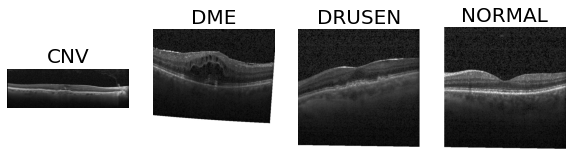

In [11]:
plot_random_image(directory = train_dir, class_names = class_names)

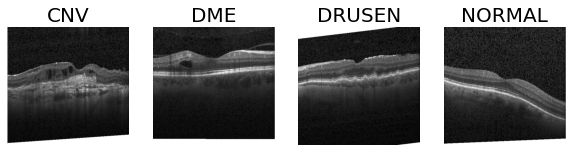

In [12]:
plot_random_image(directory = test_dir, class_names = class_names)

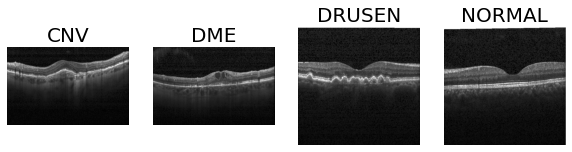

In [13]:
plot_random_image(directory = valid_dir, class_names = class_names)

In [14]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [15]:
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable=False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = base_model(inputs, training=False) #Put the base model in inference mode, and so weights ehich remains frozen, remains frozen
x = layers.Conv2D(64, (3, 3), activation = 'relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation="relu")(x)
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

71696384/71686520 [==============================] - 3s 0us/step


In [16]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, None, None, 1792)  17673823  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 64)          1032256   
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               160100    
_________________________________________________________________
output_layer (Dense)         (None, 4)                 404       
Total params: 18,866,583
Trainable params: 1,192,760
Non-trainable params: 17,673,823
_________________________________________

In [18]:
base_model.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [19]:
history = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(valid_data)
                    )

Epoch 1/10
2609/2609 [==============================] - 946s 345ms/step - loss: 0.3449 - accuracy: 0.8756 - precision: 0.8943 - recall: 0.8577 - val_loss: 0.0241 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/10
2609/2609 [==============================] - 896s 343ms/step - loss: 0.2318 - accuracy: 0.9191 - precision: 0.9263 - recall: 0.9116 - val_loss: 0.0136 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
2609/2609 [==============================] - 915s 350ms/step - loss: 0.1832 - accuracy: 0.9358 - precision: 0.9411 - recall: 0.9303 - val_loss: 0.0311 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/10
2609/2609 [==============================] - 894s 342ms/step - loss: 0.1471 - accuracy: 0.9480 - precision: 0.9521 - recall: 0.9445 - val_loss: 0.0079 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/10
2609/2609 [==============================] - 914s 350ms/step - loss: 

In [20]:
model.save("Retinal_OCT")

INFO:tensorflow:Assets written to: Retinal_OCT/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


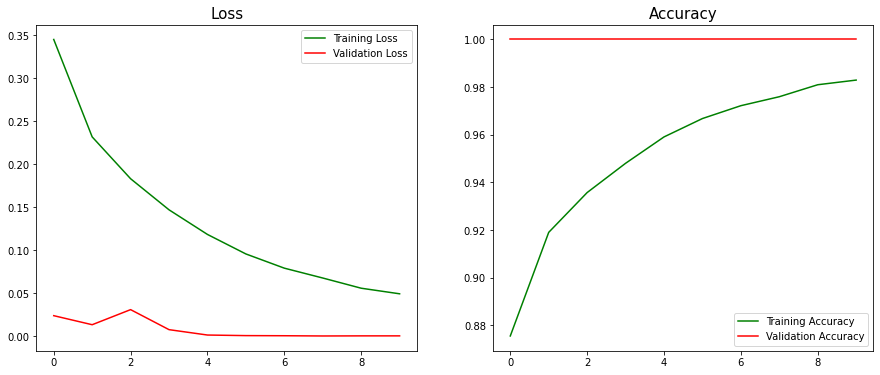

In [21]:
loss = history.history["loss"]
accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["val_accuracy"]

epochs = range(len(loss))

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label = "Training Loss", color='green')
plt.plot(epochs, val_loss, label = "Validation Loss", color='red')
plt.legend()
plt.title("Loss", fontsize=15)

plt.subplot(1,2,2)
plt.plot(epochs, accuracy, label = "Training Accuracy", color='green')
plt.plot(epochs, val_accuracy, label = "Validation Accuracy", color='red')
plt.legend()
plt.title("Accuracy", fontsize=15)
plt.show();

In [22]:
cp -R Retinal_OCT /content/drive/MyDrive/Kaggle/Retinal

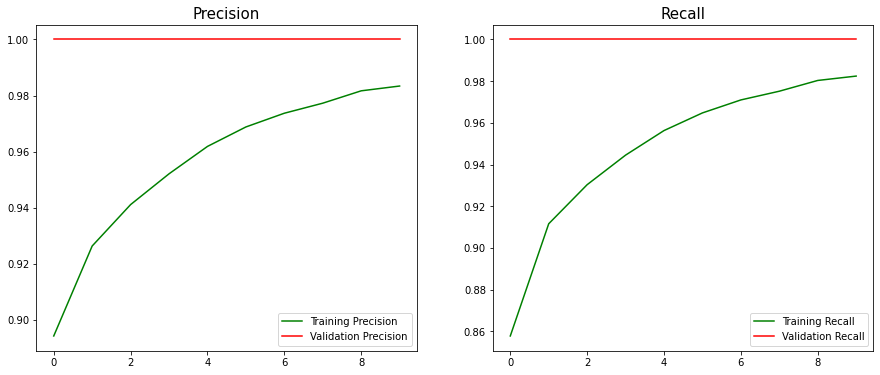

In [23]:
precision = history.history["precision"]
recall = history.history["recall"]
val_precision = history.history["val_precision"]
val_recall = history.history["val_recall"]

epochs = range(len(loss))

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(epochs, precision, label = "Training Precision", color='green')
plt.plot(epochs, val_precision, label = "Validation Precision", color='red')
plt.legend()
plt.title("Precision", fontsize=15)

plt.subplot(1,2,2)
plt.plot(epochs, recall, label = "Training Recall", color='green')
plt.plot(epochs, val_recall, label = "Validation Recall", color='red')
plt.legend()
plt.title("Recall", fontsize=15)
plt.show();

In [24]:
evaluation_result = model.evaluate(test_data)

31/31 [==============================] - 12s 380ms/step - loss: 0.0949 - accuracy: 0.9680 - precision: 0.9690 - recall: 0.9680


In [25]:
evaluation_result

[0.09485601633787155,
 0.9679751992225647,
 0.9689761996269226,
 0.9679751992225647]

In [26]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [28]:
pred_probs = model.predict(test_data)
pred_probs

array([[9.9999940e-01, 2.6767924e-10, 5.4742736e-07, 4.1475043e-13],
       [9.9644995e-01, 2.1898391e-05, 3.5282334e-03, 9.7823118e-11],
       [9.9999356e-01, 2.3906981e-07, 6.2083868e-06, 7.3784617e-11],
       ...,
       [1.5641868e-08, 1.5885929e-05, 1.6239428e-06, 9.9998248e-01],
       [5.0650600e-10, 4.2861982e-05, 1.0844583e-03, 9.9887270e-01],
       [3.8763499e-08, 6.4394607e-07, 2.8204830e-05, 9.9997103e-01]],
      dtype=float32)

In [30]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [31]:
len(pred_classes)

968

In [32]:
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently test labels are one hot encoded like [0, 0, 0, 1, 0, ...... 0, 0, 0]

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [33]:
len(y_labels)

968

In [34]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)

In [35]:
class_names

array(['CNV', 'DME', 'DRUSEN', 'NORMAL'], dtype='<U6')

In [38]:
# make_confusion_matrix(y_true=y_labels,
#                       y_pred=pred_classes,
#                       classes=class_names,
#                       figsize=(100,100),
#                       text_size=20,
#                       savefig=True)

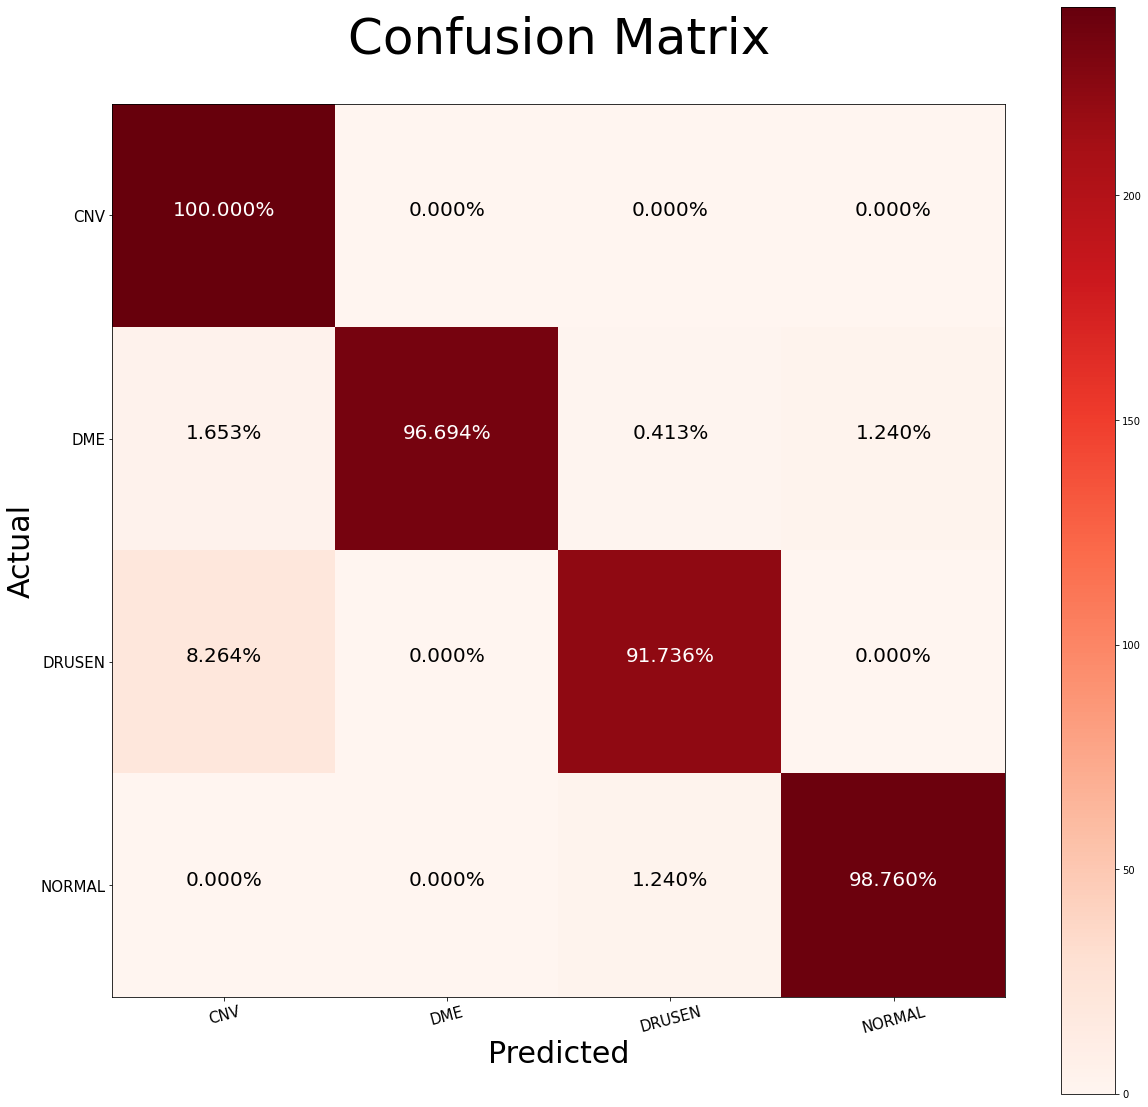

In [64]:
cm = confusion_matrix(y_labels, pred_classes)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0] # find the number of classes we're dealing with

# Plot the figure and make it pretty
fig, ax = plt.subplots(figsize=(20,20))
cax = ax.matshow(cm, cmap=plt.cm.Reds) # colors will represent how 'correct' a class is, darker == better
fig.colorbar(cax)

# Are there a list of classes?
labels = class_names

plt.xticks(np.arange(len(class_names)), class_names, rotation=15, fontsize=15)
plt.yticks(np.arange(len(class_names)), class_names, fontsize=15)
plt.xlabel("Predicted", fontsize =30)
ax.xaxis.tick_bottom()
plt.ylabel("Actual", fontsize =30)
plt.title("Confusion Matrix", fontsize=50)

# Set the threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm_norm[i, j]*100:.3f}%",
            horizontalalignment="center",
            color="white" if cm_norm[i, j] > 0.5 else "black",
            size=20)

fig.savefig("confusion_matrix.png")

In [67]:
!cp /content/confusion_matrix.png /content/drive/MyDrive/Kaggle/

In [65]:
from sklearn.metrics import classification_report

In [66]:
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       242
           1       1.00      0.97      0.98       242
           2       0.98      0.92      0.95       242
           3       0.99      0.99      0.99       242

    accuracy                           0.97       968
   macro avg       0.97      0.97      0.97       968
weighted avg       0.97      0.97      0.97       968



In [68]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.952755905511811,
  'precision': 0.9097744360902256,
  'recall': 1.0,
  'support': 242},
 '1': {'f1-score': 0.9831932773109243,
  'precision': 1.0,
  'recall': 0.9669421487603306,
  'support': 242},
 '2': {'f1-score': 0.9487179487179487,
  'precision': 0.9823008849557522,
  'recall': 0.9173553719008265,
  'support': 242},
 '3': {'f1-score': 0.987603305785124,
  'precision': 0.987603305785124,
  'recall': 0.987603305785124,
  'support': 242},
 'accuracy': 0.9679752066115702,
 'macro avg': {'f1-score': 0.968067609331452,
  'precision': 0.9699196567077754,
  'recall': 0.9679752066115702,
  'support': 968},
 'weighted avg': {'f1-score': 0.968067609331452,
  'precision': 0.9699196567077755,
  'recall': 0.9679752066115702,
  'support': 968}}

In [69]:
class_f1_scores = {}

# Loop through the classification report dictionary items
for k, v in classification_report_dict.items():
    if k == "accuracy" : # Stop once we get to accuracy key
        break
    else:
        # Add class names and f1-scores
        class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'CNV': 0.952755905511811,
 'DME': 0.9831932773109243,
 'DRUSEN': 0.9487179487179487,
 'NORMAL': 0.987603305785124}

In [70]:
#  Turn f1 scores into dataframes
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                           "f1-scores": list(class_f1_scores.values())}).sort_values("f1-scores", ascending=False)
f1_scores

class_names  f1-scores
3      NORMAL   0.987603
1         DME   0.983193
0         CNV   0.952756
2      DRUSEN   0.948718

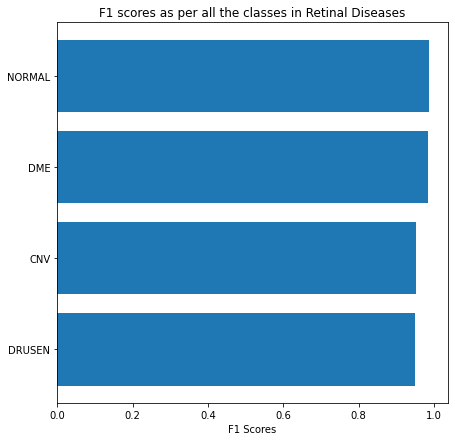

In [74]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,7))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-scores"].values)# get f1 score values

ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1 Scores")
ax.set_title("F1 scores as per all the classes in Retinal Diseases")
ax.invert_yaxis();

In [80]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_image(img, channels=3)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [85]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class} \nProbability: {pred.max()*100:.3f}%")
  plt.axis(False);

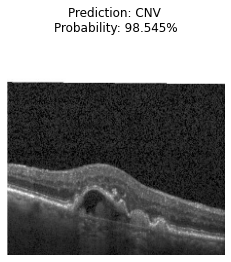

In [86]:
pred_and_plot(model = model, 
              filename = "/content/OCT2017/test/CNV/CNV-1136126-1.jpeg", 
              class_names = class_names)

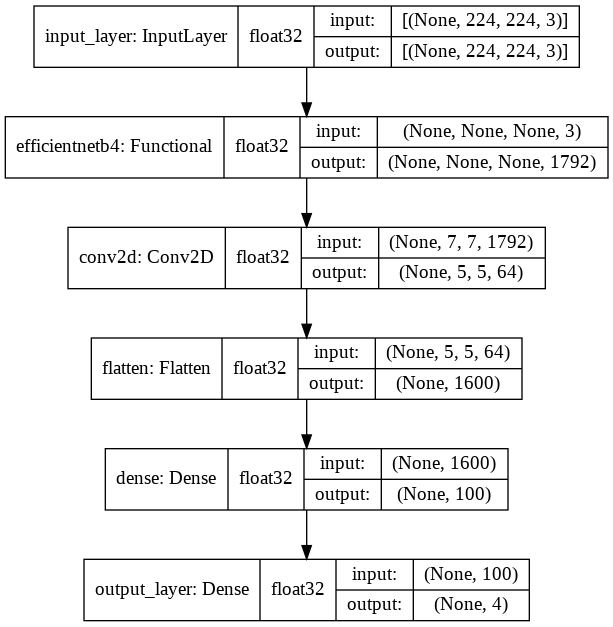

In [91]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.625098 to fit



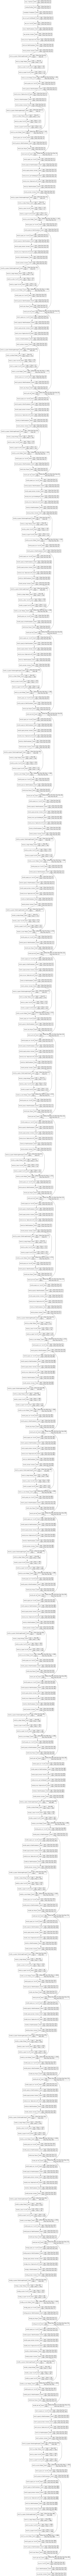

In [92]:
tf.keras.utils.plot_model(
    base_model, to_file='base_model.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)

In [93]:
!cp /content/model.png /content/drive/MyDrive/Kaggle/

In [94]:
!cp /content/base_model.png /content/drive/MyDrive/Kaggle/